# Initial Config

## Copy data from Google Drive

In [ ]:
!cp /content/drive/My\ Drive/UniProject2020/data/* ./

## Install CoreML tools

In [ ]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 5.1MB/s 


In [ ]:
!pip install scikit-learn==0.19

# Analysis of the HODA dataset

## Import

In [ ]:
# load the modules

import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from coremltools.converters import sklearn as sklearn_to_ml
from sklearn.externals import joblib

import pickle

from HodaDatasetReader import read_hoda_dataset

%pylab inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Populating the interactive namespace from numpy and matplotlib


## Helper Functions

In [ ]:
def convert_model(model_name, obj, descr):
  # Dump Model
  with open(model_name + '.pkl', 'wb') as file:
    pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)

  # Convert to Core ML Model
  model = joblib.load(model_name + '.pkl')

  print('Converting model')
  coreml_model = sklearn_to_ml.convert(model)

  coreml_model.author = 'Tadeh Alexani'
  coreml_model.license = 'MIT'
  coreml_model.short_description = descr

  print('Saving CoreML model')
  coreml_model.save(model_name + '.mlmodel')

In [ ]:
# We use this function in order to evaulate a classifier. It trains on a fraction of the data corresponding to 
# aplit_ratio, and evaulates on the rest of the data

def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

## Load Data

In [ ]:
print('Reading train dataset (Train 60000.cdb)...')
X_train, y_train = read_hoda_dataset(dataset_path='Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)

Reading train dataset (Train 60000.cdb)...


In [ ]:
print('Reading test dataset (Test 20000.cdb)...')
X_test, y_test = read_hoda_dataset(dataset_path='Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

Reading test dataset (Test 20000.cdb)...


In [ ]:
print('type(X_train): ', type(X_train))
print('X_train.dtype:', X_train.dtype)
print('X_train.shape: (reshape=True), ', X_train.shape)
print()

print('type(y_train): ', type(y_train))
print('y_train.dtype:', y_train.dtype)
print('y_train.shape: (one_hot=False), ', y_train.shape)
print()

print('type(X_test): ', type(X_test))
print('X_test.dtype:', X_test.dtype)
print('X_test.shape: (reshape=False), ', X_test.shape)
print()

print('type(y_test): ', type(y_test))
print('y_test.dtype:', y_test.dtype)
print('y_test.shape: (one_hot=True), ', y_test.shape)
print()

type(X_train):  <class 'numpy.ndarray'>
X_train.dtype: float32
X_train.shape: (reshape=True),  (60000, 1024)

type(y_train):  <class 'numpy.ndarray'>
y_train.dtype: float32
y_train.shape: (one_hot=False),  (60000,)

type(X_test):  <class 'numpy.ndarray'>
X_test.dtype: float32
X_test.shape: (reshape=False),  (20000, 1024)

type(y_test):  <class 'numpy.ndarray'>
y_test.dtype: float32
y_test.shape: (one_hot=True),  (20000,)



## Visualization

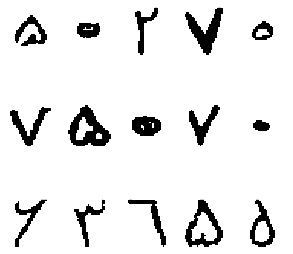

In [ ]:
# plot some of the numbers

figure(figsize(5,5))
for digit_num in range(0,15):
  subplot(3,5,digit_num+1)
  grid_data = X_train[digit_num+1].reshape(32,32)
  plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
  xticks([])
  yticks([])

In [ ]:
# Number of samples per each class:


## Machine Learning Algorithms

In [ ]:
# Conert float32 to int64
X_train = X_train.astype(numpy.int64)
y_train = y_train.astype(numpy.int64)
X_test = X_test.astype(numpy.int64)
y_test = y_test.astype(numpy.int64)

### Random Forest Num. of Estimators

In [ ]:
# check performance of random forest classifier, as function of number of estimators 
# here we only take 1000 data points to train

n_estimators_array = np.array([1,5,10,50,100,200,500])
n_samples = 10
n_grid = len(n_estimators_array)
score_array_mu =np.zeros(n_grid)
score_array_sigma = np.zeros(n_grid)
j=0
for n_estimators in n_estimators_array:
    score_array=np.zeros(n_samples)
    for i in range(0,n_samples):
        clf = RandomForestClassifier(n_estimators = n_estimators, n_jobs=1, criterion="gini")
        score_array[i] = evaluate_classifier(clf, X_train[0:1000], y_train[0:1000], 0.8)
    score_array_mu[j], score_array_sigma[j] = mean(score_array), std(score_array)
    j=j+1

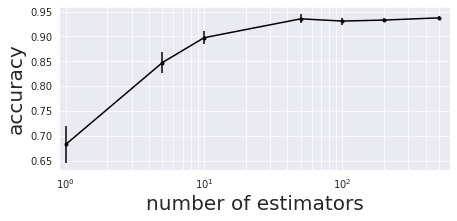

In [ ]:
# it looks like the performance saturates around 50-100 estimators

figure(figsize(7,3))
errorbar(n_estimators_array, score_array_mu, yerr=score_array_sigma, fmt='k.-')
xscale("log")
xlabel("number of estimators",size = 20)
ylabel("accuracy",size = 20)
xlim(0.9,600)
grid(which="both")

Are there any features that are particularly important? We can check this using clf.feature_importances:


Feature ranking:
1. feature 531 (0.006436)
2. feature 238 (0.005972)
3. feature 499 (0.005552)
4. feature 216 (0.005487)
5. feature 563 (0.005423)
6. feature 532 (0.005211)
7. feature 117 (0.005043)
8. feature 500 (0.004626)
9. feature 149 (0.004532)
10. feature 399 (0.004502)


Text(0, 0.5, 'importance')

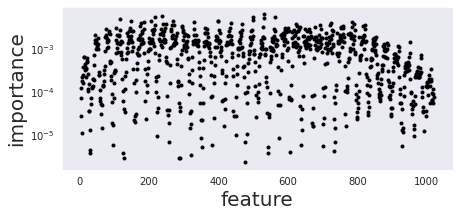

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances

figure(figsize(7,3))
plot(indices[:],importances[indices[:]],'k.')
yscale("log")
xlabel("feature",size=20)
ylabel("importance",size=20)

It looks like there are no significantly important features (i.e., pixels) in the original data. Next, let us try to decompose the data using a principal component analysis (PCA):

### PCA

Text(0, 0.5, 'PC2')

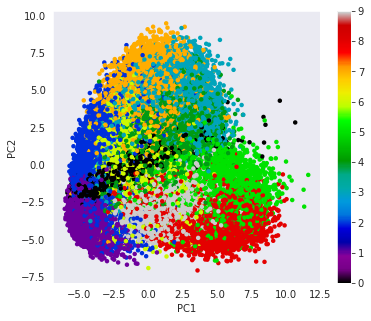

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)
transform = pca.transform(X_train)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = y_train, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,9)

xlabel("PC1")
ylabel("PC2")

It is interesting to see how well PCA separates the feature space into visible clusters already for 2 components. Next, let's look at what happens if we increase the number of components in PCA. In particular, we would like to know how many components are needed to capture most of the variance in the data. For this we will use the pca.explained_variance_ratio function.

In [ ]:
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1    

Text(0, 0.5, 'variance ratio')

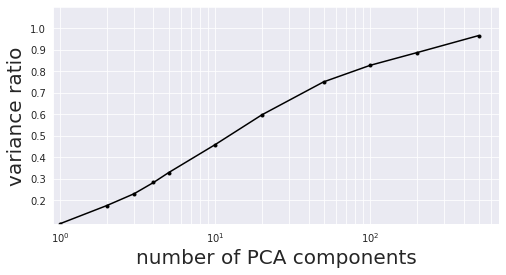

In [ ]:
figure(figsize(8,4))
plot(n_components_array,vr,'k.-')
xscale("log")
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("number of PCA components",size=20)
ylabel("variance ratio",size=20)

We see that ~100 PCA components are needed to capture ~90% of the variance in the data. This seems a lot of components. Maybe the more important question is: How good is our prediction as a function of number of components? Let's look at this next. We will train a kNN classifier on the PCA output.



In [ ]:
# here we only take 1000 data points to train

clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    transform = pca.transform(X_train[0:1000])
    score_array[i] = evaluate_classifier(clf, transform, y_train[0:1000], 0.8)
    i=i+1

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


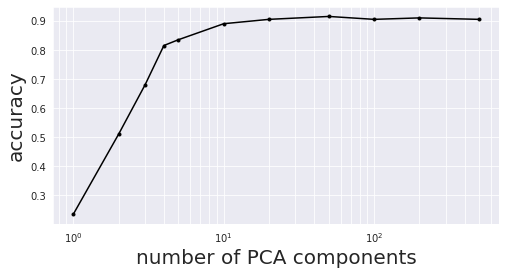

In [ ]:
figure(figsize(8,4))
plot(n_components_array,score_array,'k.-')
xscale('log')
xlabel("number of PCA components", size=20)
ylabel("accuracy", size=20)
grid(which="both")

The accuracy seems to saturate at ~ 90% (roughly matching the performance of the random forest classifier) for >~ 20 PCA components. In fact, the accuracy even seems to drop for much larger numbers, even though a larger number of PCA components captures more of the variance in the data, as seen in the plot above. The drop in accuracy is probably due to overfitting.

In [ ]:
# Final PCA Implementation
    
pca = PCA(n_components=50)
pca.fit(X_train)
transform_train = pca.transform(X_train)
transform_test = pca.transform(X_test)

# Conert float32 to int64
# transform_train = transform_train.astype(numpy.int64)
# transform_test = transform_test.astype(numpy.int64)

### kNN

In [ ]:
# kNN
kNNClf = KNeighborsClassifier()
kNNClf.fit(transform_train, y_train)
kNN_y_pred = kNNClf.predict(transform_test)

In [ ]:
kNN_acc = accuracy_score(y_test, kNN_y_pred)
print('PCA + kNN Accuracy Score: ', kNN_acc)

PCA + kNN Accuracy Score:  0.96795


### Random Forrest

In [ ]:
# random forest classification

rf_clf = RandomForestClassifier(n_estimators = 100, n_jobs=1, criterion="gini")
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

In [ ]:
rf_acc = accuracy_score(y_test, rf_y_pred)
print('Random Forest Accuracy Score: ', rf_acc)

Random Forest Accuracy Score:  0.971


### PCA + SVM

In [ ]:
svm_clf = svm.SVC(kernel='rbf',C=9)
svm_clf.fit(transform_train , y_train)

SVC(C=9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
svm_y_pred = svm_clf.predict(transform_test)

In [ ]:
svm_acc =  accuracy_score(y_test, svm_y_pred)
print('SVM Accuracy Score: ', svm_acc)

SVM Accuracy Score:  0.98615


### Logistic Regression

Don’t get confused by its name! It is a classification not a regression algorithm. It is used to estimate discrete values ( Binary values like 0/1, yes/no, true/false ) based on given set of independent variable(s). In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function. Hence, it is also known as logit regression. Since, it predicts the probability, its output values lies between 0 and 1 (as expected).

In [ ]:
# LogisticRegression
lf_clf = LogisticRegression(C=5, solver='lbfgs', multi_class='multinomial')
lf_clf.fit(X_train, y_train)

lr_y_pred = lf_clf.predict(X_test)

# Accuracy score
lr_acc = accuracy_score(y_test, lr_y_pred)
print('Logistic Regression Accuracy Score: ', lr_acc)

Logistic Regression Accuracy Score:  0.92155


## Scores

In [ ]:
models = pd.DataFrame({
    'Model': ['kNN','Random Forrest', 'PCA + SVM', 'Logistic Regression'
              ],
    'Score': [kNN_acc,rf_acc,svm_acc,lr_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,PCA + SVM,0.98615
1,Random Forrest,0.97100
0,kNN,0.96795
3,Logistic Regression,0.92155


Text(0, 0.5, 'Algorithm')

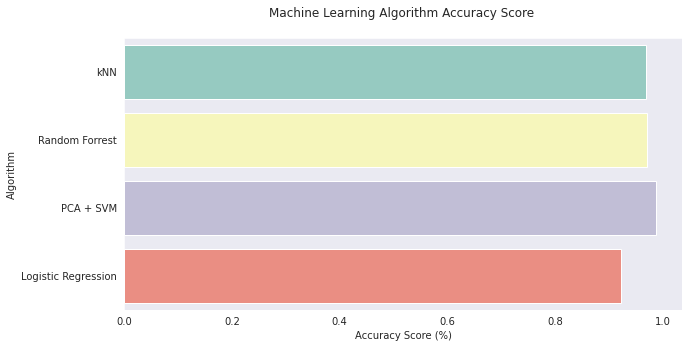

In [ ]:
plt.subplots(figsize =(10, 5))

sb.barplot(x='Score', y = 'Model', data = models, palette="Set3")

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## Convert Models

In [ ]:
convert_model('HodaModel', rf_clf, 'Random Forrest Classifier')

Converting model
Saving CoreML model


## Print Samples

([], <a list of 0 Text major ticklabel objects>)

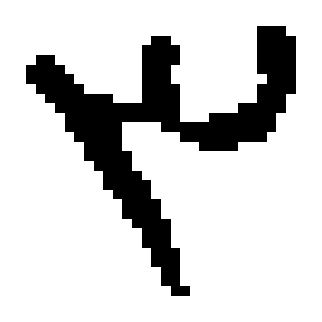

In [ ]:
figure(figsize(32,32))
subplot(3,5,1)
grid_data = X_train[16].reshape(32,32)
plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
xticks([])
yticks([])

In [ ]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# X_train[0]